In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import json
import random 
import glob
from hazm import SentenceTokenizer, WordTokenizer, Normalizer, sent_tokenize
from transformers import AutoTokenizer, GPT2LMHeadModel, pipeline, TrainingArguments, Trainer, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
import pickle
from transformers import AdamW, get_linear_schedule_with_warmup, DistilBertTokenizer
import torch.nn as nn
import math
from tqdm import tqdm
import numpy as np
import re
import pandas as pd

torch.cuda.empty_cache()
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [2]:
!nvitop

)07=Tue Jun 06 02:23:12 2023
╒═════════════════════════════════════════════════════════════════════════════╕
│ NVITOP 1.0.0        Driver Version: 460.56        CUDA Driver Version: 11.2 │
├───────────────────────────────┬──────────────────────┬──────────────────────┤
│ GPU  Name        Persistence-M│ Bus-Id        Disp.A │ Volatile Uncorr. ECC │
│ Fan  Temp  Perf  Pwr:Usage/Cap│         Memory-Usage │ GPU-Util  Compute M. │
╞═══════════════════════════════╪══════════════════════╪══════════════════════╡
│   0  GeForce RTX 3090    Off  │ 00000000:0B:00.0 Off │                  N/A │
│ 73%   56C    P3    92W / 350W │      3MiB / 23.70GiB │      0%      Default │
╘═══════════════════════════════╧══════════════════════╧══════════════════════╛
[ CPU: ██▍ 8.0%                           ]  ( Load Average:  1.00  0.87  0.69 )
[ MEM: ▊ 2.6%                             ]  [ SWP: ▏ 0.0%                     ]

╒══════════════════════════════════════════════════════════════════════════════╕
│ Pr

In [3]:
def make_dataset_v2(file_path):
    all_paragraphs = []
    for file in glob.glob(file_path):
        with open(file, 'r') as f:
            print(f'====== file_name: {file} =======')
            if re.match(r'.*\.json$', file):
                data = json.load(f)
                for dict_ in data:
                    all_paragraphs += dict_['paragraphs']
            elif re.match(r'.*\.csv$', file):
                data = pd.read_csv(f)
                all_paragraphs += data['text'].tolist()
    print(len(all_paragraphs))
    # Extract sentences from paragraphs :
    sentences_list = []
    for paragraph in tqdm(all_paragraphs, desc = 'Sentences tokenization'):
        sentences_list += sent_tokenize(paragraph)
    # Normalize + remove extra denotations like :
    normalized_sentences_list = []
    normalizer = Normalizer()
    for sentence in tqdm(sentences_list, desc = 'Normalization'):
        normalized_sentence = re.sub('[:,،.<>/!@#$%~{}();»«…“”"؛؟◊♦–\*\+_\^]', ' ', sentence)
        normalized_sentence = normalizer.normalize(normalized_sentence)
        normalized_sentences_list.append(normalized_sentence)
    print(len(normalized_sentences_list))
    with open("dataset_sentences_v2", "wb") as fp:
                pickle.dump(normalized_sentences_list, fp)
                
                
def load_dataset(file_path):
    with open(file_path, "rb") as fp:   
        dataset_sentences = pickle.load(fp)
    return dataset_sentences


In [4]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2"):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        max_length = 200
        for txt in txt_list:
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                       truncation=True, max_length=max_length, padding="max_length")
            
            # resulting input IDs and attention masks are converted to 
            # PyTorch tensors and appended to the respective lists.
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
    # returns the length of the dataset (i.e., the number of input samples).
    def __len__(self):
        temp = len(self.input_ids)
        return temp

    # used to retrieve an item at a specific index. 
    # It returns the input IDs and attention masks corresponding to that index.
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)
    

In [15]:
data_path = 'dataset/*'
make_dataset_v2(data_path)   
sentences = load_dataset('dataset_sentences_v2')

====== file_name: dataset/namnak-4.json =======
====== file_name: dataset/hidoctor-1.json =======
====== file_name: dataset/review.csv =======
====== file_name: dataset/hidoctor-4.json =======
====== file_name: dataset/namnak-3.json =======
====== file_name: dataset/namnak-1.json =======
====== file_name: dataset/hidoctor-5.json =======
====== file_name: dataset/hidoctor-3.json =======
====== file_name: dataset/alarabiya_data.csv =======
====== file_name: dataset/namnak-5.json =======
====== file_name: dataset/namnak-2.json =======
====== file_name: dataset/hidoctor-2.json =======
60615


Normalization: 100%|█████████████████████████████████████████████████████████| 110261/110261 [00:07<00:00, 14591.25it/s]


110261


In [3]:
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian',  bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')
model = GPT2LMHeadModel.from_pretrained('bolbolzaban/gpt2-persian')
model.resize_token_embeddings(len(tokenizer)) 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Embedding(25004, 1024)

In [6]:
# make dataset
dataset_sentences = load_dataset('dataset_sentences_v2')
dataset_sentences = random.sample(dataset_sentences, int(len(dataset_sentences)))
dataset = GPT2Dataset(dataset_sentences, tokenizer)

In [7]:
# Split into training and validation sets
train_size = int(0.70 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size
batch_size = 20
epochs = 6

set_seed(555)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f'{train_size} training samples')
print(f'{val_size} validation samples')
print(f'{test_size} test samples')

# train Model 
training_args = TrainingArguments(output_dir='./results', num_train_epochs=epochs, logging_steps=50, save_steps=3000,
                                  per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size,
                                  warmup_steps=10, weight_decay=0.05, logging_dir='./logs', report_to = 'none')

trainer = Trainer(model=model,  args=training_args, train_dataset=train_dataset, 
        eval_dataset=val_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])}).train()

model.save_pretrained("./gpt2_namnak_hidoctor/model_base_on_namnak_hidoctor_dataset_v2")

77182 training samples
16540 validation samples
16539 test samples


/home/user01/miniconda3/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss
50,1.263200
100,0.506700
150,0.418100
200,0.440900
250,0.467400
300,0.463800
350,0.443800
400,0.442500
450,0.452400
500,0.409400


KeyboardInterrupt: 

# Result

In [4]:
def predict_next(model, tokenizer, text, kind, num, max_length):
    # Encode a text inputs
    generator = pipeline('text-generation', model=model, tokenizer=tokenizer,  pad_token_id=tokenizer.eos_token_id)
    if kind == 'greedy':
        outputs = generator(text, max_length=max_length, num_return_sequences=num)
    elif kind == 'beams':
        outputs = generator(text, max_length=max_length, num_beams=5, num_return_sequences=num)
    elif kind == 'random_sampling':
        outputs = generator(text, max_length=max_length, top_k=0, do_sample=True, temperature=0.7, num_return_sequences=num)
    elif kind == 'text_p_sampling':   
        outputs = generator(text, max_length=max_length, top_k=0, top_p=0.92, do_sample=True, num_return_sequences=num)

    elif kind == 'text_k_sampling':   
        outputs = generator(text, max_length=max_length, top_k=40, do_sample=True, num_return_sequences=num)
    return outputs

## Base Model

In [6]:
tokenizer_base = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
model_base = GPT2LMHeadModel.from_pretrained('bolbolzaban/gpt2-persian')

samples = [ 'احتمال خطر سکته های ', 
         'احتمال خطر سکته های م',
         'بهترین روش برای غلبه بر استرس ',
         'بهترین روش برای غلبه بر استرس ن',
         'بهترین روش برای غلبه بر استرس نوشیدن ',
        ]
num = 5
kind = 'greedy'
max_length = 20
num_words = 2
for sample in samples:
    print('input : ', sample)
    s_len = len(sample.split(' '))
    predictions = predict_next(model_base, tokenizer_base, sample, kind , num, max_length)
    for p in predictions:
        preds = p['generated_text'].split()
        print(' '.join(preds[s_len-1:s_len-1+num_words]))
    print('.................................')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


input :  احتمال خطر سکته های 
ساله از
درصد بیشتر
- قلبی
درصد وجود
‌های قلبی
.................................
input :  احتمال خطر سکته های م
مغیر قلبی
محدب مغزی
م ادر
مشد ید
متواتر پیش
.................................
input :  بهترین روش برای غلبه بر استرس 
و خستگی
و بهبود
است.
و اضطراب
و کاهش
.................................
input :  بهترین روش برای غلبه بر استرس ن
ننشینید.
ننوشیدن آب
ننوشیدن آب
ننوشیدن آب
ننوشیدن آب
.................................
input :  بهترین روش برای غلبه بر استرس نوشیدن 
آب کافی
آب سالم
آب همراه
یک لیوان
این مایعات
.................................


## Model with hidoctor/namnak dataset + alarabiyeh + lastsecond - 6 epoch

In [7]:
# trained model result 
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
model = GPT2LMHeadModel.from_pretrained('./gpt2_namnak_hidoctor/model_base_on_namnak_hidoctor_dataset_v2')

samples = [ 'احتمال خطر سکته های ', 
         'احتمال خطر سکته های م',
         'بهترین روش برای غلبه بر استرس ',
         'بهترین روش برای غلبه بر استرس ن',
         'بهترین روش برای غلبه بر استرس نوشیدن ',
        ]
num = 5
kind = 'greedy'
max_length = 20
num_words = 2
for sample in samples:
    print('input : ', sample)
    s_len = len(sample.split(' '))
    predictions = predict_next(model.to('cpu'), tokenizer, sample, kind , num, max_length)
    for p in predictions:
        preds = p['generated_text'].split()
#         print(p['generated_text'])
        print(' '.join(preds[s_len-1:s_len-1+num_words]))
    print('.................................')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


input :  احتمال خطر سکته های 
فو به
فو در
فو یا
فوبیا در
فو سکته
.................................
input :  احتمال خطر سکته های م
مگالوبلاستیک هم
مگالوبلاستیک در
ماحتمال و
مگالوبلاستیک کم
مگالوبلاستیک در
.................................
input :  بهترین روش برای غلبه بر استرس 

امتحان این
از جمله
و غلبه
و افسردگی
.................................
input :  بهترین روش برای غلبه بر استرس ن
ننوشیدن آب
ننوشیدن آب
ننوشیدن قهوه
ننوشیدن قهوه
ننوشیدن آب
.................................
input :  بهترین روش برای غلبه بر استرس نوشیدن 
آب فراوان
یک فنجان
چای کمرنگ
چای سبز
دمنوش آویشن
.................................


## Model with hidoctor + namnak dataset - 8 epoch

In [8]:
# trained model result 
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
model = GPT2LMHeadModel.from_pretrained('../gpt2_namnak_hidoctor/model_base_on_namnak_hidoctor_dataset_1')

samples = [ 'احتمال خطر سکته های ', 
         'احتمال خطر سکته های م',
         'بهترین روش برای غلبه بر استرس ',
         'بهترین روش برای غلبه بر استرس ن',
         'بهترین روش برای غلبه بر استرس نوشیدن ',
        ]
num = 5
kind = 'greedy'
max_length = 20
num_words = 2
for sample in samples:
    print('input : ', sample)
    s_len = len(sample.split(' '))
    predictions = predict_next(model.to('cpu'), tokenizer, sample, kind , num, max_length)
    for p in predictions:
        preds = p['generated_text'].split()
#         print(p['generated_text'])
        print(' '.join(preds[s_len-1:s_len-1+num_words]))
    print('.................................')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


input :  احتمال خطر سکته های 
کوپیک هم
کمتر از
فو در
فو، در
کوپلر و
.................................
input :  احتمال خطر سکته های م
مگالوبلاستیک در
مگالوبلاستیک در
مگالوبلاستیک در
مگالوبلاستیک بسیار
مقلبی در
.................................
input :  بهترین روش برای غلبه بر استرس 
و نگرانی
امتحان کنید
تعطیلات
و اضطراب،
در تعطیلات
.................................
input :  بهترین روش برای غلبه بر استرس ن
ننوشیدن آب
ننوشیدن الکل
ننوشیدن الکل.
ننوشیدن الکل
ننوشیدن الکل
.................................
input :  بهترین روش برای غلبه بر استرس نوشیدن 
آب گرم
مایعات فراوان
چای است.
آبمیوه آناناس
یک فنجان
.................................


# HyperParameters

In [5]:
# load pretrained Model 
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
model = GPT2LMHeadModel.from_pretrained('bolbolzaban/gpt2-persian')
model.resize_token_embeddings(len(tokenizer))      
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(25001, 1024)
    (wpe): Embedding(256, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout):

In [6]:
# make dataset
dataset_sentences = load_dataset('dataset_sentences_v2')
random.seed(10)
dataset_sentences = random.sample(dataset_sentences, int(len(dataset_sentences)))
dataset = GPT2Dataset(dataset_sentences, tokenizer)

In [10]:
# Split into training and validation sets
train_size = int(0.70 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size
batch_size = 14
epochs = 3

set_seed(555)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(f'{train_size} training samples')
print(f'{val_size} validation samples')
print(f'{test_size} test samples')


train_idx = list(range(0, int(0.8*len(train_dataset))))
val_idx = list(range(0, int(0.8*len(val_dataset))))
train_dataset = torch.utils.data.Subset(train_dataset, train_idx)
val_dataset = torch.utils.data.Subset(val_dataset, val_idx)


train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, batch_size = batch_size)

77182 training samples
16540 validation samples
16539 test samples


In [10]:
import torch.nn as nn
from fastai.text.all import *
import math
import matplotlib.pyplot as plt

In [11]:
def splitter(model):
    "Split a GPT2 `model` in 3 groups for differential learning rates."
    
    # First layers group : decoder blocks from 0 to 3
    modules = []
    for i in range(4): modules.append(model.transformer.h[i])
    groups = [nn.Sequential(*modules)]

    # Second layers group : decoder blocks from 4 to 7
    modules = []
    for i in range(4,8,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])

    # Third layers group : decoder blocks from 8 to 11
    modules = []
    for i in range(8,12,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])
    
    groups = L(groups + [nn.Sequential(model.transformer.wte,model.transformer.wpe,model.transformer.ln_f)])
    
    return groups.map(params)

def plot_loss(train_losses, val_losses, epoch):
    fig = plt.figure(figsize=(8,5))
    plt.plot(range(1,len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1,len(val_losses)+1), val_losses,label='Validation Loss')
    plt.xlabel('epochs steps')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot_' + str(epoch)+ '.png', bbox_inches='tight')

In [12]:
param_groups = []
learning_rates = [1e-4,2e-4,4e-4,5e-4]
param_splitter = splitter(model)
for i in range(0, len(param_splitter)):
    parameters_of_group_layer = param_splitter[i]
    for parameter in parameters_of_group_layer:
        param_groups.append({'params': [parameter], 'lr': learning_rates[i]})

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        print(param_group['lr'])
    
learning_rate = 5e-4
epsilon = 1e-8
sample_every = 100

optimizer = AdamW(param_groups,
                  lr = learning_rate,
                  eps = epsilon
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 10, 
                                            num_training_steps = total_steps)

/home/user01/miniconda3/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


======== Epoch 1 / 6 ========
  Batch   100  of  5,146. AVG TRAIN Loss: 0.9179818237772083. 
  Batch   100  of  5,146. AVG VAL Loss: 0.5495794613525636. 
  Batch   200  of  5,146. AVG TRAIN Loss: 0.5924027986194363. 
  Batch   200  of  5,146. AVG VAL Loss: 0.48923366679620006. 
  Batch   300  of  5,146. AVG TRAIN Loss: 0.4775616294422815. 
  Batch   300  of  5,146. AVG VAL Loss: 0.46555222976186117. 
  Batch   400  of  5,146. AVG TRAIN Loss: 0.41679004767440503. 
  Batch   400  of  5,146. AVG VAL Loss: 0.4615805326054989. 
  Batch   500  of  5,146. AVG TRAIN Loss: 0.38010999753684577. 
  Batch   500  of  5,146. AVG VAL Loss: 0.4532070746231598. 
  Batch   600  of  5,146. AVG TRAIN Loss: 0.35546352413053717. 
  Batch   600  of  5,146. AVG VAL Loss: 0.45083653066283663. 
  Batch   700  of  5,146. AVG TRAIN Loss: 0.3361253744780422. 
  Batch   700  of  5,146. AVG VAL Loss: 0.44862105799391394. 
  Batch   800  of  5,146. AVG TRAIN Loss: 0.32287257043795936. 
  Batch   800  of  5,146. AVG V

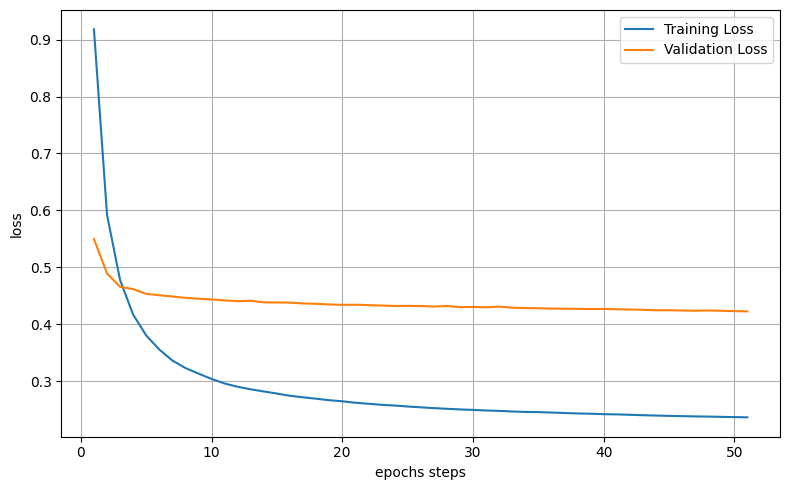

[{'epoch': 1, 'Training Loss': 0.47212516036054014, 'Valid. Loss': 0.42252789613396496}]
======== Epoch 2 / 6 ========
  Batch   100  of  5,146. AVG TRAIN Loss: 0.20582789131025275. 
  Batch   100  of  5,146. AVG VAL Loss: 0.4225751749380869. 
  Batch   200  of  5,146. AVG TRAIN Loss: 0.2013736439507399. 
  Batch   200  of  5,146. AVG VAL Loss: 0.42218607460112323. 
  Batch   300  of  5,146. AVG TRAIN Loss: 0.20060658858365. 
  Batch   300  of  5,146. AVG VAL Loss: 0.42209988477169547. 
  Batch   400  of  5,146. AVG TRAIN Loss: 0.1994275351675074. 
  Batch   400  of  5,146. AVG VAL Loss: 0.4223654053206889. 
  Batch   500  of  5,146. AVG TRAIN Loss: 0.1988266542137502. 
  Batch   500  of  5,146. AVG VAL Loss: 0.4221068510848181. 
  Batch   600  of  5,146. AVG TRAIN Loss: 0.19865760575366298. 
  Batch   600  of  5,146. AVG VAL Loss: 0.42225835863450173. 
  Batch   700  of  5,146. AVG TRAIN Loss: 0.19735073906166237. 
  Batch   700  of  5,146. AVG VAL Loss: 0.42205677222686794. 
  Batch 

In [ ]:
def evaluate(model, validation_dataloader):
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():        
            outputs  = model(b_input_ids, attention_mask = b_masks, labels=b_labels)
            loss = outputs[0]  

        batch_loss = loss.item()
        total_eval_loss += batch_loss        
        
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    return avg_val_loss
    
    
 # Gradual Layer Freezing(First layer)
param_splitter = splitter(model)
parameters_layer1 = param_splitter[0]
for param in parameters_layer1:
    param.requires_grad = False

training_stats = []
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    total_train_loss = 0
    model.train()
    train_numder = 0
    train_losses = []
    val_losses = []
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        
        outputs = model(b_input_ids, labels=b_labels, attention_mask = b_masks, token_type_ids=None)

        loss = outputs[0]  
        batch_loss = loss.item()
        total_train_loss += batch_loss
        train_numder += len(batch)

        if step % sample_every == 0 and not step == 0:
            train_losses.append(total_train_loss/train_numder)
            print('  Batch {:>5,}  of  {:>5,}. AVG TRAIN Loss: {:>5,}. '.format(step, len(train_dataloader), total_train_loss/train_numder))
            model.eval()    
            avg_val_loss = evaluate(model, validation_dataloader)
            val_losses.append(avg_val_loss)
            print('  Batch {:>5,}  of  {:>5,}. AVG VAL Loss: {:>5,}. '.format(step, len(train_dataloader), avg_val_loss))
            model.train()
                    
        loss.backward()
        optimizer.step()
        scheduler.step()
            
    avg_train_loss = total_train_loss / len(train_dataloader)       
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print(f"  Perplexity: {math.exp(avg_train_loss):.2f}")
    print("")

    model.eval()    
    avg_val_loss = evaluate(model, validation_dataloader)
    print("  Validation Loss : {0:.2f}".format(avg_val_loss))
    print(f"  Perplexity: {math.exp(avg_val_loss):.2f}")
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )
    # Gradual Layer Freezing
    if epoch_i == 0:
        param_splitter = splitter(model)
        parameters_layer2 = param_splitter[1]
        for param in parameters_layer2:
            param.requires_grad = False
        plot_loss(train_losses, val_losses, epoch_i)
        
    if epoch_i == 1:
        param_splitter = splitter(model)
        parameters_layer3 = param_splitter[2]
        for param in parameters_layer3:
            param.requires_grad = False
        plot_loss(train_losses, val_losses, epoch_i)
    
    if epoch_i == 2:
        param_splitter = splitter(model)
        parameters_layer4 = param_splitter[3]
        for param in parameters_layer4:
            param.requires_grad = False
        plot_loss(train_losses, val_losses, epoch_i)
            
    model.save_pretrained('./gpt2_namnak_hidoctor/deep_model_on_namnak_hidoctor_dataset_epoch_i_' + str(epoch_i))
    print(training_stats)
    with open("training_stats", "wb") as fp:   
        pickle.dump(training_stats, fp)

In [15]:
# trained model result 
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
model = GPT2LMHeadModel.from_pretrained('./gpt2_namnak_hidoctor/deep_model_on_namnak_hidoctor_dataset_epoch_i_1')

samples = [ 'احتمال خطر سکته های ', 
         'احتمال خطر سکته های م',
         'بهترین روش برای غلبه بر استرس ',
         'بهترین روش برای غلبه بر استرس ن',
         'بهترین روش برای غلبه بر استرس نوشیدن ',
        ]
num = 5
kind = 'greedy'
max_length = 20
num_words = 2
for sample in samples:
    print('input : ', sample)
    s_len = len(sample.split(' '))
    predictions = predict_next(model.to('cpu'), tokenizer, sample, kind , num, max_length)
    for p in predictions:
        preds = p['generated_text'].split()
#         print(p['generated_text'])
        print(' '.join(preds[s_len-1:s_len-1+num_words]))
    print('.................................')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


input :  احتمال خطر سکته های 
قلبی و
قلبی را
قلبی ناشی
- مغزی
پرترومبین هم
.................................
input :  احتمال خطر سکته های م
مغذی برای
مغزی را
مگالوبلاستیک <<unk>sndof<unk>e
مگالوبلاستیک در
مغیر قلبی
.................................
input :  بهترین روش برای غلبه بر استرس 
خود چه
تان در
یا جلوگیری
ی که
‌های روزانه
.................................
input :  بهترین روش برای غلبه بر استرس ن
ننشینین و
ننشینین و
ننشینید <<unk>sndof<unk>e
ننوشیدن الکل
نپوشیدن لباسهای
.................................
input :  بهترین روش برای غلبه بر استرس نوشیدن 
یک فنجان
چای سیاه
یک فنجان
آب است
چای و
.................................
